## Python notebook for SOM

### Diego Polo 3/5/2020
Inpiration taken from
http://www.ai-junkie.com/ann/som/som1.html
https://visualstudiomagazine.com/articles/2019/01/01/self-organizing-maps-python.aspx
http://blog.yhat.com/posts/self-organizing-maps-2.html

In [92]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

## Dataset

#    Data will be a collection of random colours, so first we’ll artificially create a dataset of 100.
#    Each colour is a 3D vector representing R, G and B values


raw_data = np.random.randint(0,255, size=(3,20))
print(raw_data.shape)

(3, 20)


In [93]:
## Setup

network_dimensions = np.array([1, 3])
n_iterations = 5000
init_learning_rate = 0.1

m = raw_data.shape[0]
n = raw_data.shape[1]

# weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
# in this case, a matrix of 5x5 but and each element is an array of 3 dimensions (m)
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

In [94]:
## Normalisation

# Another detail to discuss at this point is whether or not we normalise our dataset.
# First of all, SOMs train faster (and “better”) if all our values are between 0 and 1.
# This is to avoid one of our dimensions “dominating” the others in the learning process.

# we want to keep a copy of the raw data for later
data = raw_data

normalise_data = True
normalise_by_column = False # no need as all colums have same range

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data =   raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()


In [95]:
## Learning

# decay the SOM parameters
# We want to decay the learning rate over time to let the SOM “settle” on a solution.

# What we also decay is the neighbourhood radius, which defines how far we search for 2D neighbours when updating vectors in the SOM. 
# We want to gradually reduce this over time, like the learning rate.

# The functions to decay the radius and learning rate use exponential decay: σt = σ0·exp(-t/λ)
# Where λ is the time constant (which controls the decay) and σ is the value at various times t.

def decay_radius(initial_radius, iteration, lambdaa):
    return initial_radius * np.exp(-iteration / lambdaa)

def decay_learning_rate(initial_learning_rate, iteration, n_iterations):
    return initial_learning_rate * np.exp(-iteration / n_iterations)



# Find the neuron in the SOM whose associated 3D vector is closest to our chosen 3D colour vector.
# At each step, this is called the Best Matching Unit (BMU)
#     For that to work we need a function to find the BMU. It need to iterate through each neuron in the SOM, measure its Euclidean distance to our input vector and return the one that’s closest. Note the implementation trick of not actually measuring Euclidean distance, but the squared Euclidean distance, thereby avoiding an expensive square root computation.

def find_bmu(t, net):
    """
    Find the best matching unit for a given vector, t, in the SOM
    Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                and bmu_idx is the index of this vector in the SOM
    """
    min_dist = np.Infinity
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :]
            # calculate kinda Euclidean distance
            dist = np.sum((w - t)**2)
            if dist < min_dist:
                min_dist = dist
                x_min = x
                y_min = y
    # get the vector corresponding to x_min and y_min
    return (x_min, y_min)

# Move the BMU’s 3D weight vector closer to the input vector in 3D space
# The formula to update the BMU’s 3D vector is: Wt+1 = Wt + L(Vt-Wt)
# That is to say, the new weight vector will be the current vector plus the difference between the input vector V
# and the weight vector, multiplied by a learning rate L at time t

# We also identify all the neurons in the SOM that are closer in 2D space than our current radius, and also move them closer to the input vector.
# The difference is that the weight update will be proportional to their 2D distance from the BMU.
# One last thing to note: this proportion of 2D distance isn’t uniform, it’s Gaussian.
# Concretely, this is the equation we’ll use to calculate the influence i
# It = exp(-d²/2σt²)
# where d is the 2D distance and σ is the current radius of our neighbourhood.

def influence(dist, radius):
    return np.exp(-dist**2/(2*radius**2))



In [96]:
# Repeating step n_iterations
for iteration in range(n_iterations):
    # select a random value of the input vector
    t = data[:, np.random.randint(data.shape[1])].flatten()
    # get bmu and coordinates
    x_min, y_min = find_bmu(t, net)


    r = decay_radius(init_radius, iteration, lambdaa=n_iterations / (init_radius))
    l = decay_learning_rate(init_learning_rate, iteration, n_iterations)
    print(r,":", l)
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :]
            dist = (x - x_min)**2 + (y - y_min)**2

            if dist < r**2:
                w = w + l*(t-w)*influence(dist, r)
                net[x, y] = w



762675184274
0.3865342141320609 : 0.04049466293265049
0.38641827126012174 : 0.04048656480990323
0.386302363165827 : 0.04047846830661857
0.3861864898387455 : 0.040470373422472644
0.3860706512684482 : 0.04046228015714165
0.38595484744450975 : 0.040454188510301886
0.3858390783565079 : 0.04044609848162966
0.3857233439940233 : 0.040438010070801375
0.38560764434663997 : 0.04042992327749351
0.38549197940394475 : 0.040421838101382564
0.38537634915552815 : 0.04041375454214516
0.3852607535909831 : 0.04040567259945793
0.3851451926999062 : 0.04039759227299763
0.38502966647189685 : 0.04038951356244101
0.3849141748965579 : 0.04038143646746494
0.38479871796349463 : 0.04037336098774634
0.3846832956623165 : 0.04036528712296218
0.3845679079826352 : 0.04035721487278952
0.3844525549140658 : 0.04034914423690545
0.38433723644622664 : 0.04034107521498715
0.38422195256873903 : 0.040333007806711875
0.3841067032712274 : 0.04032494201175692
0.3839914885433193 : 0.04031687782979964
0.3838763083746455 : 0.04030881

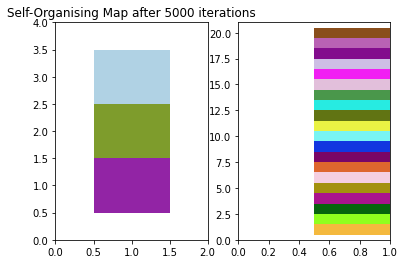

In [97]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
#plt.show()

# setup axes
bx = fig.add_subplot(122)
bx.set_xlim((0, 1))
bx.set_ylim((0, data.shape[1]+1))

# plot the rectangles
for x in range(1, 2):
    for y in range(1, data.shape[1] + 1):
        bx.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=data[:, y-1],
                     edgecolor='none'))
plt.show()